In [99]:
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
import dotenv
import pendulum
from sqlalchemy import create_engine, desc
from sqlalchemy.orm import sessionmaker
from config import Settings
from models import MessageSql
import matplotlib.pyplot as plt

settings = Settings(_env_file=dotenv.find_dotenv())
valid_password = settings.thermostat_api_key.get_secret_value()
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)


session = Session()
timezone = "America/New_York"
start = pendulum.datetime(2024, 10, 14, 12, 49, tz=timezone)
end = pendulum.datetime(2024, 10, 15, 2, 49, tz=timezone)
start_ms = int(start.timestamp() * 1000)
end_ms = int(end.timestamp() * 1000)

messages = session.query(MessageSql).filter(
    MessageSql.from_alias.like(f'%oak%'),
    MessageSql.message_persisted_ms >= start_ms,
    MessageSql.message_persisted_ms <= end_ms,
).order_by(desc(MessageSql.message_persisted_ms)).all()

In [100]:
hp_odu_pwr = []
hp_odu_pwr_times = []
hp_idu_pwr = []
hp_idu_pwr_times = []
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        if 'hp-odu-pwr' in channel['ChannelName']:
            hp_odu_pwr.extend(channel['ValueList'])            
            hp_odu_pwr_times.extend(channel['ScadaReadTimeUnixMsList'])            
        elif 'hp-idu-pwr' in channel['ChannelName']:
            hp_idu_pwr.extend(channel['ValueList'])
            hp_idu_pwr_times.extend(channel['ScadaReadTimeUnixMsList'])

hp_power_data = {
    'hp_odu_pwr': hp_odu_pwr,
    'hp_idu_pwr': hp_idu_pwr,
}

In [101]:
channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        if 'zone' in channel['ChannelName']:
            continue
        if channel['ChannelName'] not in channels:
            channels[channel['ChannelName']] = {
                'values': channel['ValueList'],
                'times': channel['ScadaReadTimeUnixMsList']
            }
        else:
            channels[channel['ChannelName']]['values'].extend(channel['ValueList'])
            channels[channel['ChannelName']]['times'].extend(channel['ScadaReadTimeUnixMsList'])

# Sort values according to time
first_time = 1e9**2
for key in channels.keys():
    sorted_times_values = sorted(zip(channels[key]['times'], channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[key]['times'] = list(sorted_times)
    channels[key]['values'] = list(sorted_values)
    if channels[key]['times'][0] < first_time:
        first_time = channels[key]['times'][0]

In [102]:
# First plot: HP loop
for key in channels.keys():
    print(key)

hp-odu-pwr
hp-idu-pwr
dist-pump-pwr
primary-pump-pwr
store-pump-pwr
oil-boiler-pwr
dist-swt
dist-rwt
hp-lwt
hp-ewt
store-hot-pipe
store-cold-pipe
buffer-hot-pipe
buffer-cold-pipe
oat
buffer-well


In [103]:
def to_fahrenheit(t):
    return t*9/5+32

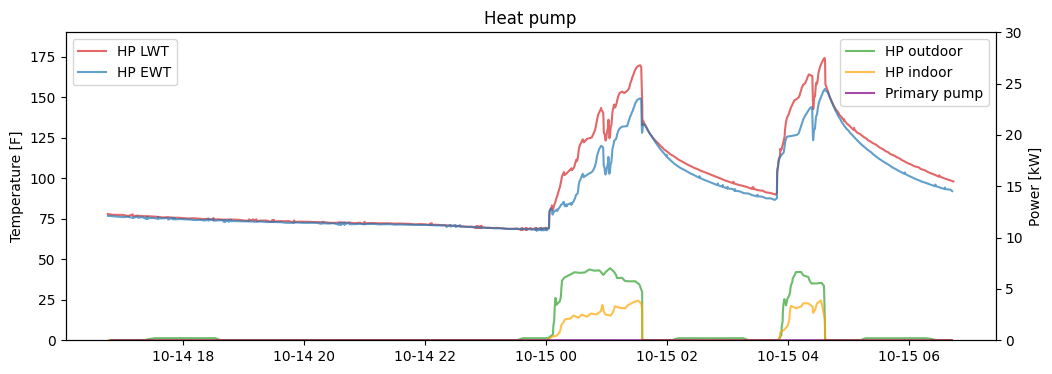

In [108]:
channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        if 'zone' in channel['ChannelName']:
            continue
        if channel['ChannelName'] not in channels:
            channels[channel['ChannelName']] = {
                'values': channel['ValueList'],
                'times': channel['ScadaReadTimeUnixMsList']
            }
        else:
            channels[channel['ChannelName']]['values'].extend(channel['ValueList'])
            channels[channel['ChannelName']]['times'].extend(channel['ScadaReadTimeUnixMsList'])

# Sort values according to time
first_time = 1e9**2
for key in channels.keys():
    sorted_times_values = sorted(zip(channels[key]['times'], channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[key]['times'] = list(sorted_times)
    channels[key]['values'] = list(sorted_values)
    if channels[key]['times'][0] < first_time:
        first_time = channels[key]['times'][0]

# First plot: HP loop
import pandas as pd
first_plot_keys = []
for key in channels.keys():

    if 'hp' in key or 'primary' in key:
        first_plot_keys.append(key)
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')
        if 'wt' in key:
            channels[key]['values'] = [to_fahrenheit(x) for x in channels[key]['values']]

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(channels['hp-lwt']['times'], channels['hp-lwt']['values'], color='tab:red', alpha=0.7, label='HP LWT')
ax.plot(channels['hp-ewt']['times'], channels['hp-ewt']['values'], color='tab:blue', alpha=0.7, label='HP EWT')
ax.set_ylabel('Temperature [F]')
ax.set_ylim([0,190])
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(channels['hp-odu-pwr']['times'], channels['hp-odu-pwr']['values'], color='tab:green', alpha=0.7, label='HP outdoor')
ax2.plot(channels['hp-idu-pwr']['times'], channels['hp-idu-pwr']['values'], color='orange', alpha=0.7, label='HP indoor')
ax2.plot(channels['primary-pump-pwr']['times'], channels['primary-pump-pwr']['values'], color='purple', alpha=0.7, label='Primary pump')
ax2.set_ylabel('Power [kW]')
ax2.set_ylim([0,30])
ax2.legend(loc='upper right')
plt.title('Heat pump')
plt.show()

# Second plot: distribution loop
import pandas as pd
second_plot_keys = []
for key in channels.keys():

    if 'dist' in key:
        second_plot_keys.append(key)
        if 'pump' not in key:
            channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')
        if 'wt' in key:
            channels[key]['values'] = [to_fahrenheit(x) for x in channels[key]['values']]

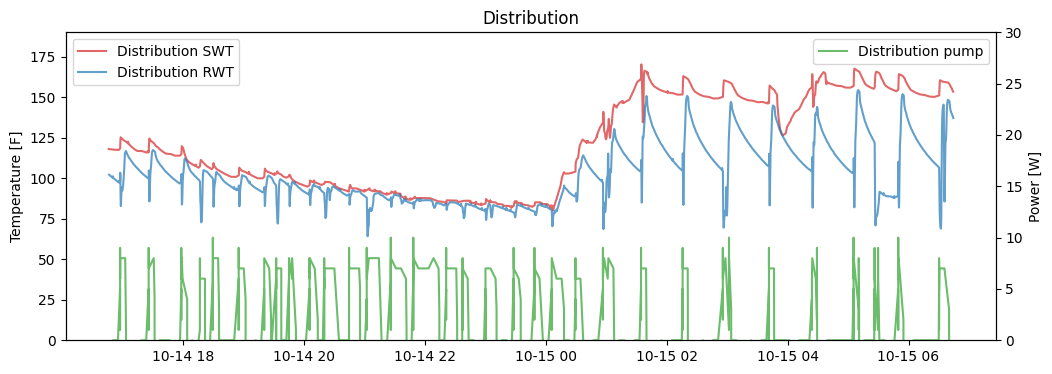

In [110]:
fig, ax = plt.subplots(1,1, figsize=(12,4))

ax.plot(channels['dist-swt']['times'], channels['dist-swt']['values'], color='tab:red', alpha=0.7, label='Distribution SWT')
ax.plot(channels['dist-rwt']['times'], channels['dist-rwt']['values'], color='tab:blue', alpha=0.7, label='Distribution RWT')
ax.set_ylabel('Temperature [F]')
ax.set_ylim([0,190])
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(channels['dist-pump-pwr']['times'], channels['dist-pump-pwr']['values'], color='tab:green', alpha=0.7, label='Distribution pump')
ax2.set_ylabel('Power [W]')
ax2.set_ylim([0,30])
ax2.legend(loc='upper right')

plt.title('Distribution')
plt.show()

In [112]:
for elem in messages[1].payload['ChannelReadingList']:
    if 'zone' in elem['ChannelName']:
        print(elem['ChannelName'])
        print(elem)
        if 'state' in elem['ChannelName']:
            print('')

zone1-living-rm-temp
{'Version': '002', 'TypeName': 'channel.readings', 'ValueList': [65000], 'ChannelName': 'zone1-living-rm-temp', 'ScadaReadTimeUnixMsList': [1728974161461]}
zone1-living-rm-set
{'Version': '002', 'TypeName': 'channel.readings', 'ValueList': [65000], 'ChannelName': 'zone1-living-rm-set', 'ScadaReadTimeUnixMsList': [1728974161461]}
zone1-living-rm-state
{'Version': '002', 'TypeName': 'channel.readings', 'ValueList': [1], 'ChannelName': 'zone1-living-rm-state', 'ScadaReadTimeUnixMsList': [1728974161461]}

zone2-garage-temp
{'Version': '002', 'TypeName': 'channel.readings', 'ValueList': [57000], 'ChannelName': 'zone2-garage-temp', 'ScadaReadTimeUnixMsList': [1728974161378]}
zone2-garage-set
{'Version': '002', 'TypeName': 'channel.readings', 'ValueList': [55000], 'ChannelName': 'zone2-garage-set', 'ScadaReadTimeUnixMsList': [1728974161378]}
zone2-garage-state
{'Version': '002', 'TypeName': 'channel.readings', 'ValueList': [0], 'ChannelName': 'zone2-garage-state', 'ScadaR